##  Learning Objectives

By the end of this comprehensive lab, you will master the following key concepts and skills:

### Theoretical Understanding
* **Grasp the overfitting problem**: Understand how complex models can memorize training data but fail to generalize
* **Learn regularization fundamentals**: Discover how L1 and L2 penalties constrain model complexity
* **Mathematical foundations**: Derive and understand the modified cost functions and gradient formulas for regularized regression

### Implementation Mastery
* **Extend cost functions**: Add L1 (Lasso) and L2 (Ridge) regularization terms to prevent overfitting
* **Vectorized gradient descent**: Implement efficient, matrix-based gradient descent algorithms for both regularization types  
* **Handle non-differentiability**: Navigate the challenges of L1 regularization's non-smooth optimization landscape
* **Professional coding practices**: Write clean, documented, and efficient machine learning code

### Practical Application
* **Real overfitting scenario**: Work with a deliberately overfitted polynomial regression model
* **Hyperparameter tuning**: Explore how regularization strength (λ) affects model behavior
* **Scikit-learn integration**: Leverage industry-standard Lasso and Ridge implementations
* **Performance evaluation**: Use RMSE and learning curves to assess model quality

### Comparative Analysis
* **Method comparison**: Systematically compare custom implementations vs. scikit-learn
* **L1 vs L2 analysis**: Understand when to use Lasso (feature selection) vs Ridge (parameter shrinkage)
* **Bias-variance tradeoff**: Observe how regularization balances underfitting and overfitting
* **Convergence behavior**: Analyze training vs. test performance across different approaches

### Key Insights You'll Gain
* Why regularization is essential for small datasets and high-dimensional features
* How L1 regularization promotes sparsity (automatic feature selection)
* Why L2 regularization provides smoother, more stable solutions
* When to choose custom implementations vs. pre-built libraries in real-world projects

## Essential Libraries and Dependencies

We'll import the core libraries needed for this comprehensive regularization lab:

- **NumPy & Matplotlib**: Numerical computing and data visualization
- **Pandas**: Data manipulation and analysis framework
- **Scikit-learn**: Professional ML implementations (Lasso, Ridge, StandardScaler)
- **Math & Copy**: Utility functions for mathematical operations and object copying 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy, math
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler

## Synthetic Dataset Creation: Setting Up for Overfitting

**Educational Purpose**: We'll deliberately create a scenario prone to overfitting:

- **Small sample size** (only ~10% for training)
- **High-dimensional features** (polynomial terms up to x^15)
- **Noisy target function** (sine wave + random noise)

This setup perfectly demonstrates why regularization is essential in machine learning!

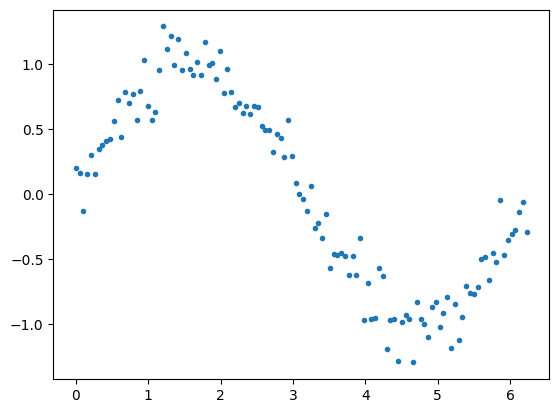

In [2]:
#Define input array with angles from 60deg to 300deg converted to radians
x = np.array([i*np.pi/60 for i in range(120)])
#x = np.array([i*np.pi/180 for i in range(360)])

np.random.seed(10)  #Setting seed for reproducibility
y = np.sin(x) + np.random.normal(0,0.15,len(x))
data = pd.DataFrame(np.column_stack([x,y]),columns=['x','y'])
plt.plot(data['x'],data['y'],'.')
plt.show()

In [3]:
for i in range(2,16):  #power of 1 is already there
    colname = 'x_%d'%i      #new var will be x_power
    data[colname] = data['x']**i
print(data.head())

         x         y       x_2       x_3       x_4           x_5  \
0  0.00000  0.199738  0.000000  0.000000  0.000000  0.000000e+00   
1  0.05236  0.159628  0.002742  0.000144  0.000008  3.935438e-07   
2  0.10472 -0.127282  0.010966  0.001148  0.000120  1.259340e-05   
3  0.15708  0.155177  0.024674  0.003876  0.000609  9.563115e-05   
4  0.20944  0.301112  0.043865  0.009187  0.001924  4.029889e-04   

            x_6           x_7           x_8           x_9          x_10  \
0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1  2.060591e-08  1.078923e-09  5.649226e-11  2.957928e-12  1.548767e-13   
2  1.318778e-06  1.381021e-07  1.446202e-08  1.514459e-09  1.585938e-10   
3  1.502171e-05  2.359604e-06  3.706457e-07  5.822090e-08  9.145317e-09   
4  8.440179e-05  1.767707e-05  3.702277e-06  7.754031e-07  1.624000e-07   

           x_11          x_12          x_13          x_14          x_15  
0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.00000

In [4]:
# split into train and test 
np.random.seed(123)
# split the data into train and test, less data is prone to overfitting, so we will only use  10% data for training
mask = np.random.rand(len(data)) < 0.1
train = data[mask]
test = data[~mask]
print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:',len(test))

Number of observations in the training data: 7
Number of observations in the test data: 113


In [5]:
# split feature and target
X_train = train.drop('y', axis=1).values
y_train = train['y'].values
X_test = test.drop('y', axis=1).values
y_test = test['y'].values

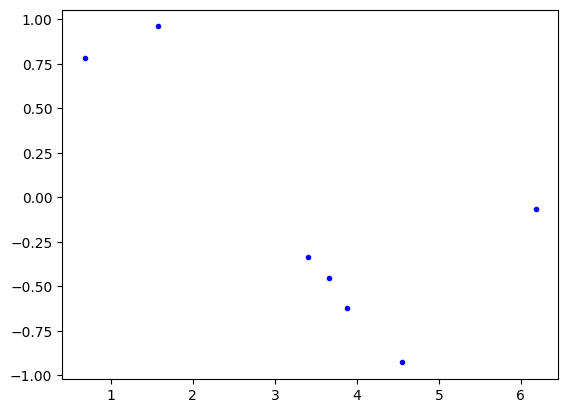

In [6]:
plt.plot(X_train[:,0], y_train, 'b.')   

## Critical Observation: The Perfect Storm for Overfitting

This is a textbook case where regularization becomes absolutely essential!

Notice the dangerous combination we've created:

- **Extremely small training set**: Only ~7-12 training instances
   - No regularization means unlimited parameter growth


- **High feature dimensionality**: 15 polynomial features  
   - Each polynomial term can memorize individual training points

- **Complex underlying pattern**: Sine wave with noise
   

**Why this leads to overfitting:**

- The model has more parameters (15) than training examples (~7-12)

In [7]:
# do standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Baseline Implementation: Vanilla Gradient Descent

### Prerequisites: Building on Previous Knowledge

Before we add regularization, let's establish our baseline with standard gradient descent. 

**Key Requirement**: Modified to track both training AND test performance to demonstrate overfitting.

**Your Task**: Implement the core gradient descent functions from your previous lab:

- `compute_cost_matrix()`: Calculate MSE cost using vectorization
- `gradient_descent_matrix()`: Main optimization loop
- `compute_gradient_matrix()`: Compute gradients efficiently 

In [8]:
def compute_cost_matrix(X, y, w):
    """
    Computes the Mean Squared Error cost for linear regression using vectorization
    
    Mathematical Formula: J(w) = (1/2m) * ||Xw - y||²
    
    Args:
      X (ndarray (m,n+1)): Feature matrix, m training examples with n+1 features (including bias)
      y (ndarray (m,)): Target values for training examples
      w (ndarray (n+1,)): Model parameters (weights + bias)
      
    Returns:
      cost (scalar): Mean squared error cost
      

    Implementation Hint:    return cost

      Use vectorized operations: (X @ w - y).T @ (X @ w - y) / (2*m)    

    """    # Formula: J = (1/2m) * (predictions - targets)^2
    # TODO: Implement vectorized MSE cost calculation
    m = X.shape[0]
    error = X @ w - y
    cost = error.T @ error / (2*m)
    return cost

In [9]:
def compute_gradient_matrix(X, y, w):
    """
    Computes the gradient of MSE cost w.r.t. parameters using vectorization
    
    Mathematical Formula: ∇J(w) = (1/m) * X.T @ (Xw - y)
    
    Args:
      X (ndarray (m,n+1)): Feature matrix with bias column
      y (ndarray (m,)): Target values 
      w (ndarray (n+1,)): Current model parameters
      
    Returns:
      dj_dw (ndarray (n+1,)): Gradient vector for all parameters
      
    Implementation Hint:

      Vectorized form avoids loops: X.T @ (predictions - targets) / m    return dj_dw

    """    

    # TODO: Implement vectorized gradient calculation    # Formula: dJ/dw = (1/m) * X.T * (X*w - y)

    m = X.shape[0]
    error = X @ w - y
    dj_dw = (X.T @ error) / m
    return dj_dw

## Enhanced Gradient Descent: Tracking Overfitting in Real-Time

- Return both cost histories for visualization

**Critical Modification**: We need to monitor BOTH training and test performance simultaneously to observe overfitting as it happens.

- Print progress every 1000 iterations for monitoring
- Calculate test cost at each iteration (without updating weights on test data)

**Key Requirements:**

- Track training cost at each iteration

In [10]:
def gradient_descent_matrix(X, y, X_test, y_test, w_in, alpha, num_iters): 
    """
    Performs batch gradient descent to learn w. Updates w by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X (ndarray (?,n+1))   : Training set, ? examples with n features
      y (ndarray (?,))    : target values in test set
      X_test (ndarray (?,n+1))   : Test set, ? examples with n features
      y_test (ndarray (?,))    : target values in test set
      w_in (ndarray (n+1,)) : initial model parameters  
      alpha (float)       : Learning rate
      num_iters (int)     : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n+1,)) : Updated values of parameters
      J_history           : Cost of the model on the training set after each iteration
      test_J_history      : Cost of the model on test set after each iteration
      """
    
    # implement the batch gradient descent algorithm using the compute_gradient and compute_cost functions

    J_history = []
    test_J_history = []

    w = copy.deepcopy(w_in)
    for i in range(num_iters):
        gradient = compute_gradient_matrix(X, y, w)
        w = w - alpha * gradient
        cost = compute_cost_matrix(X, y, w)
        test_cost = compute_cost_matrix(X_test, y_test, w)
        J_history.append(cost)
        test_J_history.append(test_cost)
        if i % 1000 == 0:
            print(f"Iteration {i:4}: Train Cost {cost:8.2f} Test Cost {test_cost:8.2f}")
    
    return w, J_history, test_J_history

## Testing Your Implementation: Demonstrating Overfitting

**Expected Outcome**: You should observe the training cost decreasing while test cost increases - classic overfitting!

**Experiment Parameters:**

- Learning rate: `alpha = 0.1` (aggressive for faster convergence)
- Data: Use standardized features (`X_train_scaled`, `X_test_scaled`)
- Iterations: `num_iters = 50000` (ensure full convergence)

In [11]:
# Do the gradient descent with the scaled data
# add a column of ones to the X_train
X_train_scaled_1 = np.column_stack((np.ones(X_train_scaled.shape[0]), X_train_scaled))
X_test_scaled_1 = np.column_stack((np.ones(X_test_scaled.shape[0]), X_test_scaled))

# initialize the model parameters to 0
w_initial = np.zeros(X_train_scaled_1.shape[1])
# run the gradient descent algorithm for 1000 iterations with a learning rate of 0.01 and lambda = 0.1
alpha = 0.1
num_iters = 50000
w_vanilla, J_history, test_J_history = gradient_descent_matrix(X_train_scaled_1, y_train, X_test_scaled_1, y_test, w_initial, alpha, num_iters)

print(f"w found by gradient descent: {w_vanilla}")

Iteration    0: Train Cost     0.19 Test Cost     0.21
Iteration 1000: Train Cost     0.01 Test Cost     0.08
Iteration 2000: Train Cost     0.01 Test Cost     0.07
Iteration 3000: Train Cost     0.01 Test Cost     0.06
Iteration 4000: Train Cost     0.01 Test Cost     0.05
Iteration 5000: Train Cost     0.00 Test Cost     0.04
Iteration 6000: Train Cost     0.00 Test Cost     0.04
Iteration 7000: Train Cost     0.00 Test Cost     0.04
Iteration 8000: Train Cost     0.00 Test Cost     0.04
Iteration 9000: Train Cost     0.00 Test Cost     0.03
Iteration 10000: Train Cost     0.00 Test Cost     0.03
Iteration 11000: Train Cost     0.00 Test Cost     0.03
Iteration 12000: Train Cost     0.00 Test Cost     0.03
Iteration 13000: Train Cost     0.00 Test Cost     0.03
Iteration 14000: Train Cost     0.00 Test Cost     0.04
Iteration 15000: Train Cost     0.00 Test Cost     0.04
Iteration 16000: Train Cost     0.00 Test Cost     0.04
Iteration 17000: Train Cost     0.00 Test Cost     0.04
It

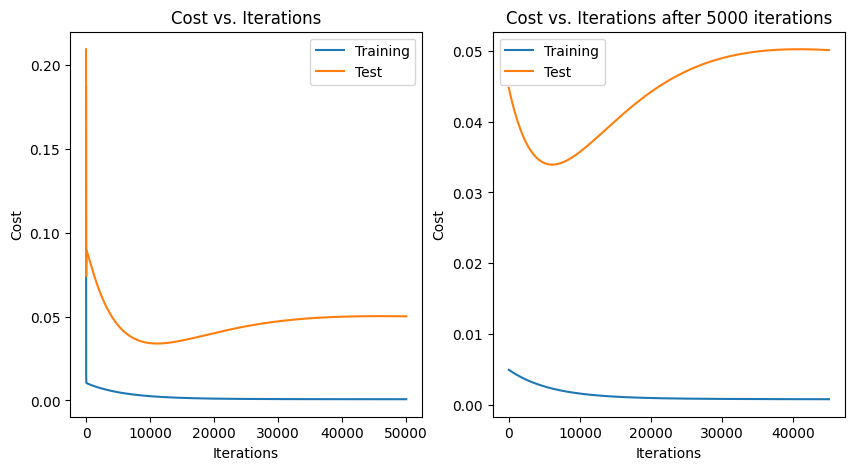

In [12]:
# putting the learning curve to show the overfitting issue of the model
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(J_history, label='Training')
axs[0].plot(test_J_history, label='Test')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Cost')
axs[0].set_title('Cost vs. Iterations')
axs[0].legend()

axs[1].plot(J_history[5000:], label='Training')
axs[1].plot(test_J_history[5000:], label='Test')
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('Cost')
axs[1].set_title('Cost vs. Iterations after 5000 iterations')
axs[1].legend()

plt.show()

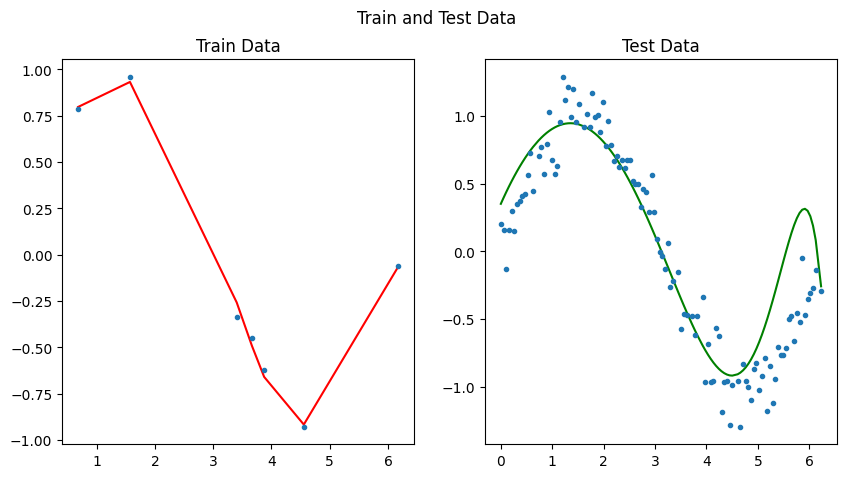

In [13]:
# plot the model on the train and test data
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Train and Test Data')
axs[0].plot(X_train[:, 0:1], X_train_scaled_1 @ w_vanilla, 'r')
axs[0].plot(X_train[:, 0:1], y_train, '.')
axs[0].set_title('Train Data')
axs[1].plot(X_test[:, 0:1], X_test_scaled_1 @ w_vanilla, 'g')
axs[1].plot(X_test[:, 0:1], y_test, '.')
axs[1].set_title('Test Data')
plt.show()


In [14]:
# output the final RMSE for the training and test set
gd_rmse_train = math.sqrt(J_history[-1])
gd_rmse_test = math.sqrt(test_J_history[-1])
print("Final training RMSE: ",gd_rmse_train)
print("Final test RMSE: ", gd_rmse_test)

Final training RMSE:  0.02750514893730219
Final test RMSE:  0.22388332864957156


## Analysis: Overfitting Confirmed!

**The Solution**: Add regularization to constrain parameter growth and improve generalization. 

**What You Should Observe:**

- **Training RMSE**: Very low (model memorized training data)
  - **The Problem**: Our model learned the noise, not the underlying pattern!

- **Test RMSE**: Much higher (poor generalization)

- **Learning curves**: Training cost ↓, Test cost ↑ (diverging lines)
- **Visualizations**: Perfect fit on training, erratic on test data

## Regularization: The Overfitting Solution

**Core Concept**: Add a penalty term to the cost function that discourages large parameter values.

**Why Regularization Works:**
- **Constrains model complexity** by limiting parameter magnitude
- **Improves generalization** by preventing memorization of training noise
- **Provides smoothness** by preferring simpler, more stable solutions
- **Reduces variance** while introducing controlled bias

**Two Main Regularization Types:**
- **L1 (Lasso)**: λ||w||₁ - Promotes sparsity, drives weights to exactly zero
- **L2 (Ridge)**: λ||w||₂² - Shrinks weights smoothly, keeps all features active

**Mathematical Intuition**: Both add penalty terms that grow with parameter magnitude, forcing the optimizer to balance fitting the data with keeping weights small.

<b>Cost function for L1 regularized linear regression</b>
\begin{equation}
J(w) = 1/2m \sum_{i=1}^{m} (f_{\mathbf{w}}(\mathbf{x})^{(i)} - y^{(i)})^2 +\lambda/2m\sum_{j=1}^{n} |w_j|  \tag{1}
\end{equation}

**Vectorized L1 Regularized Cost Function with Summation**

\begin{equation}
J(W) = \frac{1}{2m} (XW - y)^T (XW - y) + \lambda \sum_{j=1}^{n} |w_j|   \tag{2}
\end{equation}

**L1 In Vectorized Form**

\begin{equation}
J(W) = \frac{1}{2m} (XW - y)^T (XW - y) + \lambda \| W \|_1   \tag{3}
\end{equation}

<b>Cost function for L2 regularized linear regression</b>

\begin{equation}
J(w) = 1/2m \sum_{i=1}^{m} (f_{\mathbf{w}}(\mathbf{x})^{(i)} - y^{(i)})^2 +\lambda/2m\sum_{j=1}^{n} w_j^2   \tag{4}
\end{equation}


**Vectorized L2 Regularized Cost Function with Summation**

\begin{equation}
J(W) = \frac{1}{2m} (XW - y)^T (XW - y) + \lambda \sum_{j=1}^{n} w_j^2    \tag{5}
\end{equation}

**L2 Regularized Cost Function in Vectorized Form**

\begin{equation}
J(W) = \frac{1}{2m} (XW - y)^T (XW - y) + \frac{\lambda}{2} \| W \|_2^2    \tag{6}
\end{equation}


Compare this to the cost function without regularization (which you implemented in  a previous lab), which is of the form:


\begin{equation} 
J(W) = \frac{1}{2m} (XW - y)^T (XW - y)    \tag{7}
\end{equation}



The difference is the regularization term,  <span style="color:red">
    $\frac{\lambda}{2m}  \sum_{j=1}^{n} w_j^2$ </span> and <span style="color:red">
    $\frac{\lambda}{2m} \sum_{j=1}^{n} |w_j|$ 
    
Including this term encourages gradient descent to minimize the size of the parameters.

 **Note, in this example, the parameter $w_0$ is not regularized. This is standard practice.**

## Gradient descent with regularization
The basic algorithm for running gradient descent does not change with regularization, it is:
$$\begin{align*}
&\text{repeat until convergence:} \; \lbrace \\
&  \; \; \;w_j = w_j -  \alpha \frac{\partial J(\mathbf{w})}{\partial w_j} \tag{1}  \; & \text{for j := 0..n} \\    
&\rbrace
\end{align*}$$
Where each iteration performs simultaneous updates on $w_j$ for all $j$.

What changes with regularization is computing the gradients. Let's try L2 regularization next

## Gradient For L2 regularization 

\begin{equation}
\frac{\partial J(w)}{\partial w_j} = 1/m\sum_{i=1}^{m}(f_{\mathbf{w}}(\mathbf{x})^{(i)} - y^{(i)}).x_j^{(i)} + (\lambda/m)x_j^{(i)}  \tag{8}
\end{equation}

    
The term which adds regularization is  the <span style="color:red"> 
$\frac{\lambda}{m} w_j ^{(i)}$</span>, the parameter $w_0$ is not regularized

**Vectorized form**

\begin{equation}
W := W - \alpha \left( \frac{1}{m} X^T (XW - y) + \lambda W \right)    \tag{9}
\end{equation}



### Task 1: L2 Regularization Implementation (Ridge Regression)

**Critical Note**: Do NOT regularize the bias term (w₀) - standard ML practice!

**Objective**: Implement L2 regularization to combat overfitting through parameter shrinkage.

- **Implementation**: Use vectorization for efficiency

**Key Mathematical Changes:**- **Gradient**: Add λ * w regularization term to standard gradient
- **Cost function**: Add λ/2 * ||w||₂² penalty term

In [15]:
def compute_cost_matrix_reg_l2(X, y, w, lambda_reg):
    """
    🎯 Computes L2 regularized cost for linear regression (Ridge Regression)
    
    Mathematical Formula: 
    J(w) = (1/2m) * ||Xw - y||² + (λ/2) * ||w[1:]||²
    
    Args:
      X (ndarray (m,n)): Feature matrix (including bias column)
      y (ndarray (m,)): Target values
      w (ndarray (n,)): Model parameters [bias, w1, w2, ..., wn]
      lambda_reg (float): Regularization strength (λ)
      
    Returns:
      cost (scalar): Total cost = MSE + L2 penalty
      
    Implementation Notes:

      - Don't regularize bias term: w[0] excluded from penalty

      - Use w[1:] for regularization term   

      - Vectorized: λ/2 * np.sum(w[1:]**2)    # cost = MSE_cost + (lambda_reg/2) * sum(w[1:]^2)

    """    # TODO: Implement L2 regularized cost

    m = X.shape[0]
    error = X @ w - y
    mse_cost = error.T @ error / (2*m)
    reg_cost = (lambda_reg/2) * np.sum(w[1:]**2) 
    cost = mse_cost + reg_cost
    return cost

In [16]:
# Function to calculate the gradient with L2 regularization
def compute_gradient_matrix_reg_l2(X, y, w, lambda_reg):
    """
    Computes the gradient for linear regression with L2 regularization
    
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters
      lambda_reg (float): regularization parameter
      
    Returns
      dj_dw (ndarray (n,1)): The gradient of the cost w.r.t. the parameters w.
    """
    # use vectorization to implement the gradient for linear regression with L2 regularization, do not regularize the bias term
    
    m = X.shape[0]
    error = X @ w - y
    dj_dw = (X.T @ error) / m
    reg_term = np.zeros_like(w)
    reg_term[1:] = lambda_reg * w[1:]
    dj_dw = dj_dw + reg_term
    return dj_dw
 


In [17]:
# Function to perform gradient descent with L2 regularization
def gradient_descent_matrix_reg_l2(X, y, X_test, y_test, w_in, alpha, num_iters, lambda_reg):
    """
    Performs batch gradient descent to learn w. Updates w by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X (ndarray (?,n+1))   : Training Data, m examples with n features
      y (ndarray (?,))    : Training target values
      X_test (ndarray (?,n+1))   : Test set, m examples with n features
      y_test (ndarray (?,))    : target values in test set
      w_in (ndarray (n+1,)) : initial model parameters  
      alpha (float)       : Learning rate
      num_iters (int)     : number of iterations to run gradient descent
      lambda_reg (float)  : regularization parameter
      
    Returns:
      w (ndarray (n+1,)) : Updated values of parameters
      J_history           : Cost of the model after each iteration
      test_J_history      : Cost of the model on test set after each iteration
      """
    
    # implement the batch gradient descent algorithm with L2 regularization using the compute_gradient and compute_cost functions
    J_history = []
    test_J_history = []
    w = copy.deepcopy(w_in)
    for i in range(num_iters):
        gradient = compute_gradient_matrix_reg_l2(X, y, w, lambda_reg)
        w = w - alpha * gradient
        cost = compute_cost_matrix_reg_l2(X, y, w, lambda_reg)
        test_cost = compute_cost_matrix_reg_l2(X_test, y_test, w, lambda_reg)
        J_history.append(cost)
        test_J_history.append(test_cost)
   

        # print cost every 5000 iterations
        if i % 5000 == 0:
            print(f"Iteration {i:4}: Cost {cost:8.2f}   Test Cost {test_cost:8.2f}")
    return w, J_history, test_J_history


In [18]:
# initialize the model parameters to 0
w = np.zeros(X_train_scaled_1.shape[1])
# run the gradient descent algorithm for 1000 iterations with a learning rate of 0.01 and lambda = 0.1
alpha = 0.1
num_iters = 60000
lambda_l2 = 0.004
GD_L2_w, J_history, test_J_history = gradient_descent_matrix_reg_l2(X_train_scaled_1, y_train, X_test_scaled_1, y_test, w, alpha, num_iters, lambda_l2)
print(f"w found by gradient descent with regularization: {GD_L2_w} ")


Iteration    0: Cost     0.19   Test Cost     0.21
Iteration 5000: Cost     0.01   Test Cost     0.07
Iteration 10000: Cost     0.01   Test Cost     0.07
Iteration 15000: Cost     0.01   Test Cost     0.07
Iteration 20000: Cost     0.01   Test Cost     0.07
Iteration 25000: Cost     0.01   Test Cost     0.07
Iteration 30000: Cost     0.01   Test Cost     0.07
Iteration 35000: Cost     0.01   Test Cost     0.07
Iteration 40000: Cost     0.01   Test Cost     0.07
Iteration 45000: Cost     0.01   Test Cost     0.07
Iteration 50000: Cost     0.01   Test Cost     0.07
Iteration 55000: Cost     0.01   Test Cost     0.07
w found by gradient descent with regularization: [-0.09443169 -0.12710524 -0.84087173 -0.46145683 -0.04360064  0.18438483
  0.26328053  0.2601221   0.22025551  0.16868462  0.11767676  0.07246361
  0.03465799  0.00414512 -0.01991663 -0.03858886] 


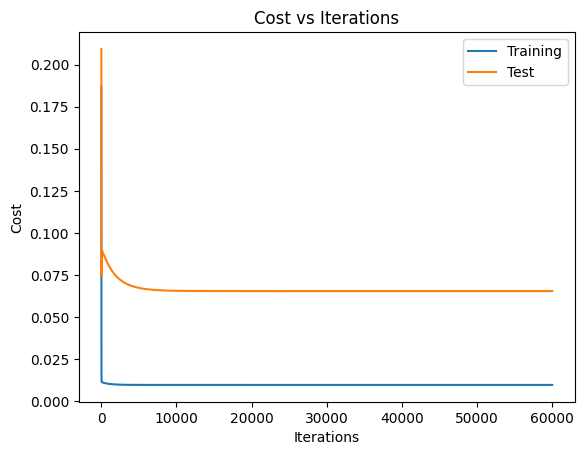

In [19]:
# plot the cost over the iterations
plt.plot(J_history, label='Training')
plt.plot(test_J_history, label='Test')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs Iterations')
plt.legend()
plt.show()

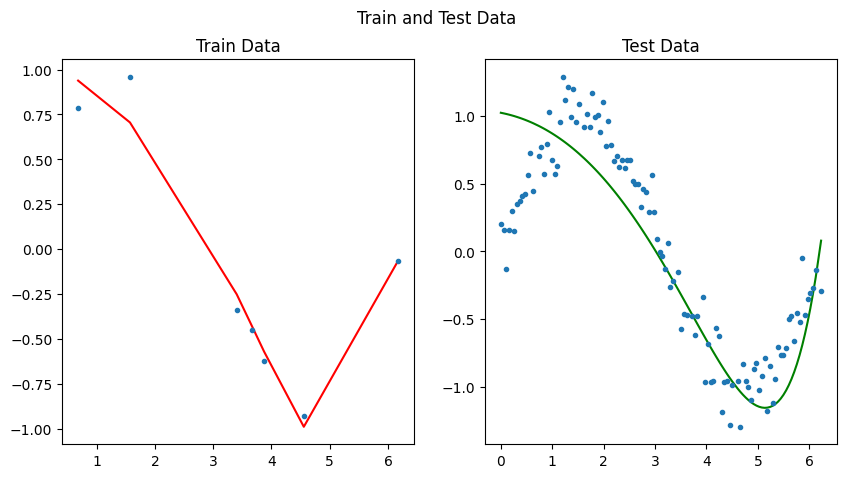

In [20]:
# putting the above figures side by side for comparision, using subplots
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Train and Test Data')
axs[0].plot(X_train[:, 0:1], X_train_scaled_1 @ GD_L2_w, 'r')
axs[0].plot(X_train[:, 0:1], y_train, '.')
axs[0].set_title('Train Data')
axs[1].plot(X_test[:, 0:1], X_test_scaled_1 @ GD_L2_w, 'g')
axs[1].plot(X_test[:, 0:1], y_test, '.')
axs[1].set_title('Test Data')
plt.show()


### Task2: output the final RMSE for the training and test set below for performance comparision at the end

In [21]:
# output the final RMSE for the training and test set
gd_l2_rmse_train = math.sqrt((X_train_scaled_1 @ GD_L2_w - y_train).T @ (X_train_scaled_1 @ GD_L2_w - y_train) / (2*X_train_scaled_1.shape[0]))
gd_l2_rmse_test = math.sqrt((X_test_scaled_1 @ GD_L2_w - y_test).T @ (X_test_scaled_1 @ GD_L2_w - y_test) / (2*X_test_scaled_1.shape[0]))
print("Final training RMSE: ",gd_l2_rmse_train)
print("Final test RMSE: ", gd_l2_rmse_test)


Final training RMSE:  0.0857852789515362
Final test RMSE:  0.2511820456697551


## Using L1 Regularization to fix the overfitting issue

The L1 gradient formula can be found below.

\begin{equation}
W := W - \alpha \left( \frac{1}{m} X^T (XW - y) + \lambda \, \text{sgn}(W) \right)    \tag{10}
\end{equation}


### L1 Implementation Challenges: Understanding the Difficulties

Using gradient descent for L1 regularization (Lasso) presents unique optimization challenges:

#### Primary Challenge: Non-differentiability
* **Problem**: The L1 penalty |w| is not differentiable at w = 0
* **Impact**: Gradient becomes undefined at zero points, causing optimization instability
* **Result**: Standard gradient descent may struggle near sparse solutions

#### Professional Solutions:

* **Coordinate Descent**: Update one parameter at a time (sklearn's approach)Let's implement L1 regularization and observe both its benefits and challenges!

* **Subgradient Methods**: Use sign function approximation (our approach)

* **Proximal Methods**: Advanced techniques for non-smooth optimization**Key Insight**: This is why professional libraries like sklearn use specialized algorithms rather than vanilla gradient descent for Lasso regression.

* **Soft Thresholding**: Analytical solutions for certain cases

We'll implement the subgradient method using `np.sign()` to approximate the L1 gradient. While this may show some convergence challenges, it demonstrates the core concepts and mathematical foundations.

#### Our Educational Approach

### Task 3: L1 Regularization Implementation (Lasso Regression)

**Expected Outcome**: Some polynomial features should be eliminated (coefficients → 0)!

**Objective**: Implement L1 regularization for automatic feature selection and overfitting prevention.

- **Sparsity**: Expect some coefficients to become exactly zero

**Key Implementation Details:**

- **Sign function**: Use np.sign() for gradient computation

- **Cost function**: Add λ * ||w||₁ penalty term
- **Gradient**: Add λ * sign(w) to standard gradient  

In [22]:
# Function to calculate the cost with L1 regularization
def compute_cost_matrix_reg_l1(X, y, w, lambda_reg):
    """
    Computes the cost for linear regression with L1 regularization
    
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters
      lambda_reg (float): regularization parameter
      
    Returns
      cost: (scalar)
    """
    # use vectorization to implement the cost for linear regression with L1 regularization, do not regularize the bias term
    m = X.shape[0]
    error = X @ w - y
    mse_cost = error.T @ error / (2*m)
    reg_cost = lambda_reg * np.sum(np.abs(w[1:])) 
    cost = mse_cost + reg_cost
    return cost

In [23]:
# Function to calculate the gradient with L1 regularization
def compute_gradient_matrix_reg_l1(X, y, w, lambda_reg):
    """
    Computes the gradient for linear regression with L1 regularization
    
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters
      lambda_reg (float): regularization parameter
      
    Returns
      dj_dw (ndarray (n,1)): The gradient of the cost w.r.t. the parameters w.
    """
    # use vectorization to implement the gradient for linear regression with L1 regularization, do not regularize the bias term
    m = X.shape[0]
    error = X @ w - y
    dj_dw = (X.T @ error) / m
    reg_term = np.zeros_like(w)
    reg_term[1:] = lambda_reg * np.sign(w[1:])
    dj_dw = dj_dw + reg_term
    return dj_dw

In [24]:
# Function to perform gradient descent with L1 regularization
def gradient_descent_matrix_reg_l1(X, y, X_test, y_test, w_in, alpha, num_iters, lambda_reg):
    """
    Performs batch gradient descent to learn w. Updates w by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X (ndarray (?,n+1))   : Training Data, m examples with n features
      y (ndarray (?,))    : Training target values
      X_test (ndarray (?,n+1))   : Test set, m examples with n features
      y_test (ndarray (?,))    : target values in test set
      w_in (ndarray (n+1,)) : initial model parameters  
      alpha (float)       : Learning rate
      num_iters (int)     : number of iterations to run gradient descent
      lambda_reg (float)  : regularization parameter
      
    Returns:
      w (ndarray (n+1,)) : Updated values of parameters
      J_history           : Cost of the model after each iteration
      test_J_history      : Cost of the model on test set after each iteration
      """
    
    # implement the batch gradient descent algorithm using the compute_gradient and compute_cost functions
    J_history = []
    test_J_history = []
    w = copy.deepcopy(w_in)
    for i in range(num_iters):
        gradient = compute_gradient_matrix_reg_l1(X, y, w, lambda_reg)
        w = w - alpha * gradient
        cost = compute_cost_matrix_reg_l1(X, y, w, lambda_reg)
        test_cost = compute_cost_matrix_reg_l1(X_test, y_test, w, lambda_reg)
        J_history.append(cost)
        test_J_history.append(test_cost)

        # print cost every 5000 iterations
        if i % 5000 == 0:
            print(f"Iteration {i:4}: Cost {cost:8.2f}   Test Cost {test_cost:8.2f}")
    return w, J_history, test_J_history
       

In [25]:
# initialize the model parameters to 0
w_initial = np.zeros(X_train_scaled_1.shape[1])
# run the gradient descent algorithm for 1000 iterations with a learning rate of 0.01 and lambda = 0.1
alpha = 0.1
num_iters = 60000
lambda_l1 = 0.004
GD_L1_w, J_history, test_J_history = gradient_descent_matrix_reg_l1(X_train_scaled_1, y_train, X_test_scaled_1, y_test, w_initial, alpha, num_iters, lambda_l1)
print(f"w found by gradient descent with L1 regularization: {GD_L1_w} ")


Iteration    0: Cost     0.19   Test Cost     0.21
Iteration 5000: Cost     0.02   Test Cost     0.08
Iteration 10000: Cost     0.02   Test Cost     0.07
Iteration 15000: Cost     0.02   Test Cost     0.07
Iteration 20000: Cost     0.02   Test Cost     0.07
Iteration 25000: Cost     0.02   Test Cost     0.07
Iteration 30000: Cost     0.02   Test Cost     0.07
Iteration 35000: Cost     0.02   Test Cost     0.07
Iteration 40000: Cost     0.02   Test Cost     0.07
Iteration 45000: Cost     0.02   Test Cost     0.07
Iteration 50000: Cost     0.02   Test Cost     0.07
Iteration 55000: Cost     0.02   Test Cost     0.07
w found by gradient descent with L1 regularization: [-9.44316904e-02 -2.42660402e-04 -1.26770170e+00 -1.50046555e-04
  2.27850348e-04  8.30161175e-04  7.19878654e-04  4.33345641e-01
  5.63682830e-01  6.31180501e-02  7.47759075e-04  5.95705010e-04
  4.08788838e-04  5.49690995e-04  4.09960494e-04  6.91874326e-04] 


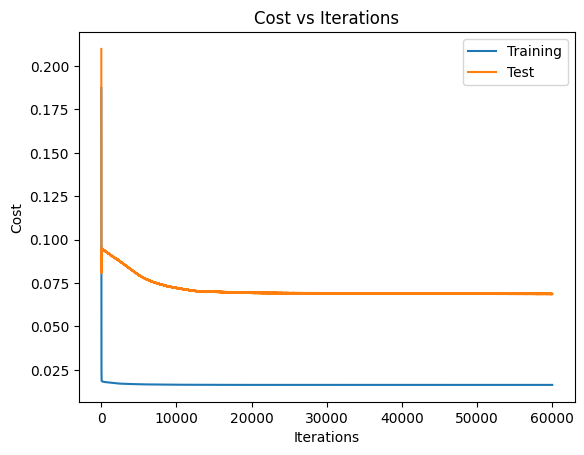

In [26]:
# plot the cost over the iterations
plt.plot(J_history, label='Training')
plt.plot(test_J_history, label='Test')

plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs Iterations')
plt.legend()
plt.show()

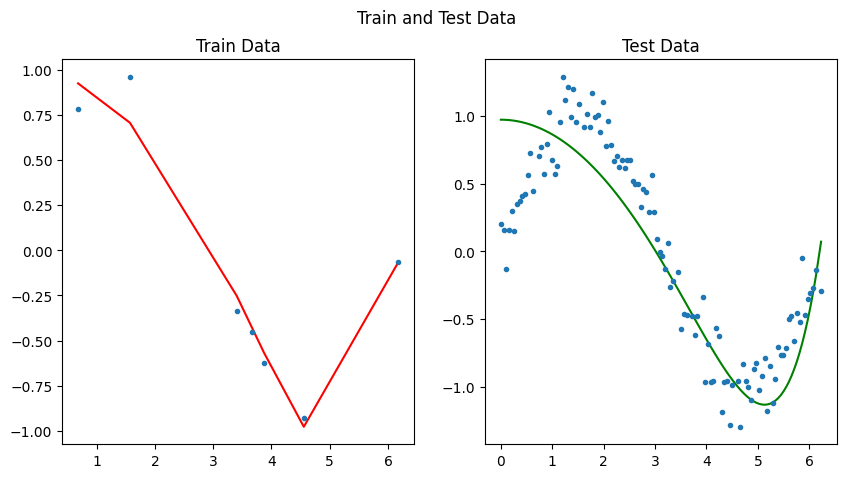

In [27]:
# putting the above figures side by side for comparision, using subplots
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Train and Test Data')
axs[0].plot(X_train[:, 0:1], X_train_scaled_1 @ GD_L1_w, 'r')
axs[0].plot(X_train[:, 0:1], y_train, '.')
axs[0].set_title('Train Data')
axs[1].plot(X_test[:, 0:1], X_test_scaled_1 @ GD_L1_w, 'g')
axs[1].plot(X_test[:, 0:1], y_test, '.')
axs[1].set_title('Test Data')
plt.show()


### Task4: output the final RMSE for the training and test set below for performance comparision at the end

In [28]:
# output the final RMSE for the training and test set
gd_l1_rmse_train = math.sqrt((X_train_scaled_1 @ GD_L1_w - y_train).T @ (X_train_scaled_1 @ GD_L1_w - y_train) / (2*X_train_scaled_1.shape[0]))
gd_l1_rmse_test = math.sqrt((X_test_scaled_1 @ GD_L1_w - y_test).T @ (X_test_scaled_1 @ GD_L1_w - y_test) / (2*X_test_scaled_1.shape[0]))
print("Final training RMSE: ",gd_l1_rmse_train)
print("Final test RMSE: ", gd_l1_rmse_test)

Final training RMSE:  0.08346816108755611
Final test RMSE:  0.2435447142672677


## Professional Implementation: Scikit-Learn's Optimized Algorithms


**Why Compare with Sklearn?**

- **Parameters**: Different hyperparameter conventions (alpha vs. lambda)

- **Industry Standard**: Production-ready, optimized implementations
- **Performance**: Optimized C/Fortran backends for speed

- **Advanced Algorithms**: Coordinate descent for Lasso, efficient solvers for Ridge
- **Stability**: Professional implementations handle edge cases better

- **Performance Benchmark**: Compare your implementations with professional tools
- **Convergence**: Sklearn may converge faster due to advanced optimization

- **Real-World Relevance**: Understand when to build custom vs. use libraries


### Task 5: Professional Ridge Regression with Scikit-Learn

**Comparison Focus**: How do sklearn's parameters compare to your custom implementation?

**Implementation Requirements:**

- Use `Ridge(alpha=0.004, max_iter=10000)` for fair comparison- Extract learned parameters using `.coef_` and `.intercept_`

- Fit on scaled training data: `X_train_scaled`, `y_train`- Predict on both training and test sets

In [29]:
# use Ridge regression from sklearn to learn the model parameters
# alpha=0.004, max_iter=10000 
ridge_model = Ridge(alpha=0.004, max_iter=10000)
ridge_model.fit(X_train_scaled, y_train)
train_preds = ridge_model.predict(X_train_scaled)
test_preds = ridge_model.predict(X_test_scaled)

print("Learned intercept:", ridge_model.intercept_)
print("Learned parameters:", ridge_model.coef_)





Learned intercept: -0.09443169035226882
Learned parameters: [ 0.68317146 -2.07864713 -1.01132877  0.1916362   0.76887686  0.87940349
  0.75488447  0.54324044  0.32025102  0.11897939 -0.04962267 -0.18499861
 -0.29087521 -0.37226435 -0.4340992 ]


### Task6: Output the RMSE for the Ridge regression

In [30]:
# output the final RMSE for the training and test set
from sklearn.metrics import mean_squared_error
ridge_train_rmse = math.sqrt(mean_squared_error(y_train, train_preds))
ridge_test_rmse = math.sqrt(mean_squared_error(y_test, test_preds))
print("Final training RMSE: ",ridge_train_rmse)
print("Final test RMSE: ", ridge_test_rmse)


Final training RMSE:  0.06859784497256222
Final test RMSE:  0.25930279992193206


### Task 7: Professional Lasso Regression with Scikit-Learn

**Sparsity Investigation**: Which polynomial terms does Lasso eliminate as irrelevant?

**Implementation Requirements:**

- Use `Lasso(alpha=0.004, max_iter=10000)` for consistency
- Compare sparsity pattern with your custom L1 implementation

- Apply to standardized data for proper regularization
  
**Key Analysis**: Count how many coefficients are exactly zero

In [31]:
# Use lasso regression from sklearn to learn the model parameters
# alpha=0.004, max_iter=10000
lasso_model = Lasso(alpha=0.004, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train)
train_preds = lasso_model.predict(X_train_scaled)
test_preds = lasso_model.predict(X_test_scaled)
print("Learned intercept:", lasso_model.intercept_)
print("Learned parameters:", lasso_model.coef_)



Learned intercept: -0.09443169035226888
Learned parameters: [-0.         -1.27800488 -0.          0.          0.          0.
  0.57624013  0.49526164  0.          0.          0.          0.
  0.          0.          0.        ]


### Task 8: Lasso Performance Analysis

**Evaluation Requirements:**
- Calculate and output final RMSE for both training and test sets
- **Sparsity Analysis**: Count and report how many coefficients are exactly zero
- **Feature Selection**: Identify which polynomial terms were eliminated
- **Compare**: How does Lasso sparsity compare to your custom L1 implementation?

In [32]:
# output the final RMSE for the training and test set
lasso_train_rmse = math.sqrt(mean_squared_error(y_train, train_preds))
lasso_test_rmse = math.sqrt(mean_squared_error(y_test, test_preds))
print("Final training RMSE: ",lasso_train_rmse)
print("Final test RMSE: ", lasso_test_rmse)

print("Number of 0 coefficients:", np.sum(lasso_model.coef_ == 0))
print("Polynomial terms (x^i) eliminated for i:", np.where(lasso_model.coef_ == 0)[0] + 1)


Final training RMSE:  0.11747428469868576
Final test RMSE:  0.3432830980957859
Number of 0 coefficients: 12
Polynomial terms (x^i) eliminated for i: [ 1  3  4  5  6  9 10 11 12 13 14 15]


**Comparison**:
- Sklearn Lasso eliminated 12 out of 15 features, while custom Lasso did not completely eliminate any features.
- Custom Lasso made 11 feature coefficients very close to zero (< 0.001) but not exactly zero.
- Sklearn Lasso has more sparsity
- Custom Lasso has higher training RMSE, but generalizes better on the test set, with a lower RMSE than the Sklearn implementation.


## Comprehensive Analysis: Comparing All Approaches

**Comparative Study Objectives:**
- **Parameter Analysis**: How do learned weights differ across methods?
- **Performance Evaluation**: Which approach generalizes best?
- **Implementation Insights**: Custom vs. professional implementations  
- **Method Selection**: When to use L1 vs. L2 vs. no regularization

**Expected Discoveries:**
- Regularized models should show better generalization (lower test RMSE)
- L1 methods should produce sparse solutions with zero coefficients
- L2 methods should shrink all parameters uniformly
- Professional implementations may outperform custom gradient descent

### Task 9: Parameter Comparison Matrix

**Create a comprehensive DataFrame comparing all learned parameters:**

**Models to Include:**

- Vanilla GD (baseline overfitted model)
- Custom L2 Regularization (Ridge)
- Custom L1 Regularization (Lasso) 
- Sklearn Ridge Regression
- Sklearn Lasso Regression

**DataFrame Structure:**

- **Rows**: Each polynomial feature (x¹, x², ..., x¹⁵) + bias term
- **Columns**: Each model's learned parameters
- **Analysis**: Identify patterns, sparsity, parameter magnitude differences

**Key Questions to Investigate:**

1. Which coefficients does L1 drive to zero?
2. How do L2 parameters compare in magnitude to unregularized?
3. Are sklearn and custom implementations learning similar patterns?

- **Rows**: Each polynomial feature (x¹, x², ..., x¹⁵) + bias term

**Models to Include:**

- Vanilla GD (baseline overfitted model)

- Custom L2 Regularization (Ridge)- Sklearn Lasso Regression

- Custom L1 Regularization (Lasso) - Sklearn Ridge Regression

In [33]:
#putting all the parameters from the above models in a dataframe, adding the bias term to the model parameters
df = pd.DataFrame({
    'Vanilla GD': w_vanilla,
    'Custom L1': [GD_L1_w[0]] + list(GD_L1_w[1:]),
    'Sklearn Lasso': [lasso_model.intercept_] + list(lasso_model.coef_),
    'Custom L2': [GD_L2_w[0]] + list(GD_L2_w[1:]),
    'SklearnRidge': [ridge_model.intercept_] + list(ridge_model.coef_)
}, index=['Bias'] + ["x_1"] + list(data.columns[2:]))

df.head(20)


,Vanilla GD,Custom L1,Sklearn Lasso,Custom L2,SklearnRidge
Bias,-0.094432,-0.094432,-0.094432,-0.094432,-0.094432
x_1,1.451011,-0.000243,-0.000000,-0.127105,0.683171
x_2,-3.311383,-1.267702,-1.278005,-0.840872,-2.078647
x_3,-1.465804,-0.000150,-0.000000,-0.461457,-1.011329
x_4,0.499038,0.000228,0.000000,-0.043601,0.191636
x_5,1.352924,0.000830,0.000000,0.184385,0.768877
x_6,1.432393,0.000720,0.000000,0.263281,0.879403
x_7,1.154671,0.433346,0.576240,0.260122,0.754884
x_8,0.769085,0.563683,0.495262,0.220256,0.543240
x_9,0.393416,0.063118,0.000000,0.168685,0.320251


### Task 10: Performance Leaderboard Analysis

**Expected Insights**: Regularized models should show better generalization!

**Create a comprehensive performance comparison:**

* How do custom implementations compare to sklearn?
* When would you choose L1 vs L2 regularization?

**Metrics to Compare:**

**Metrics to Compare:**

- Training RMSE (overfitting indicator)
- Test RMSE (generalization measure) 
- Generalization Gap (Test RMSE - Train RMSE)
- Number of Zero Coefficients (sparsity measure)

**Analysis Questions:**

1. Which method has the best test performance?
2. Which method shows least overfitting (smallest gap)?
3. How do custom implementations compare to sklearn?
4. When would you choose L1 vs L2 regularization?

**Expected Insights**: Regularized models should show better generalization!

1. Which method has the best test performance?
    The method with the best test performance is the vanilla gradient descent - test RMSE is the lowest at about 0.22.
2. Which method shows least overfitting (smallest gap)?
    The method with the least overfitting is the custom L1 regularization - the generalization gap is the lowest at about 0.16.
3. How do custom implementations compare to sklearn?
    Custom L1 outperforms sklearn Lasso in train performance, test performance and generalization gap. Custom L2 slightly outperforms sklearn Ridge in test performance and generalization gap as well. Sklearn L2  slightly outperform custom L2 in terms of training RMSE.
4. When would you choose L1 vs L2 regularization?
    L1 regularization is useful when we want to perform feature selection, while L2 regularization is useful when we want to shrink the coefficients of all features.

In [34]:
# putting all the RMSE values in a dataframe
df = pd.DataFrame({
    'Vanilla GD': [gd_rmse_train, gd_rmse_test, gd_rmse_test - gd_rmse_train, np.sum(w_vanilla[1:] == 0)],
    'Custom L1': [gd_l1_rmse_train, gd_l1_rmse_test, gd_l1_rmse_test - gd_l1_rmse_train, np.sum(GD_L1_w[1:] == 0)],
    'Sklearn Lasso': [lasso_train_rmse, lasso_test_rmse, lasso_test_rmse - lasso_train_rmse, np.sum(lasso_model.coef_ == 0)],
    'Custom L2': [gd_l2_rmse_train, gd_l2_rmse_test, gd_l2_rmse_test - gd_l2_rmse_train, np.sum(GD_L2_w[1:] == 0)],
    'Sklearn Ridge': [ridge_train_rmse, ridge_test_rmse, ridge_test_rmse - ridge_train_rmse, np.sum(ridge_model.coef_ == 0)]
}, index=['Train RMSE', 'Test RMSE', 'Generalization Gap', '# of 0 coefficients'])

df.head()



,Vanilla GD,Custom L1,Sklearn Lasso,Custom L2,Sklearn Ridge
Train RMSE,0.027505,0.083468,0.117474,0.085785,0.068598
Test RMSE,0.223883,0.243545,0.343283,0.251182,0.259303
Generalization Gap,0.196378,0.160077,0.225809,0.165397,0.190705
# of 0 coefficients,0.000000,0.000000,12.000000,0.000000,0.000000


## Congratulations! You've Mastered Regularized Machine Learning!


### Key Achievements Unlocked:

#### Technical Mastery

* **Regularized Cost Functions**: Successfully extended MSE with L1/L2 penalty terms
* **Advanced Gradient Descent**: Implemented vectorized algorithms with regularization
* **Professional Tools**: Leveraged scikit-learn's optimized Lasso and Ridge implementations
* **Comparative Analysis**: Systematically evaluated custom vs. professional approaches

#### Conceptual Understanding 

* **Overfitting Recognition**: Identified and diagnosed overfitting through learning curves
* **Bias-Variance Tradeoff**: Observed how regularization balances model complexity
* **L1 vs L2 Intuition**: Understood sparsity (L1) vs. shrinkage (L2) effects
* **Hyperparameter Impact**: Explored how λ controls regularization strength

#### Professional Insights

* **When to Regularize**: Small datasets + high dimensions = regularization essential
* **Method Selection**: L1 for feature selection, L2 for smooth parameter shrinkage
* **Implementation Choices**: Custom for learning, sklearn for production
* **Performance Evaluation**: Always compare training vs. test performance

### Real-World Applications

You're now equipped to tackle overfitting in:

- **Medical Diagnosis**: High-dimensional genomic data
- **Financial Modeling**: Feature-rich economic indicators 
- **Image Recognition**: Pixel-level feature engineering
- **Natural Language Processing**: Large vocabulary models

**Next Steps**: Apply these techniques to your own datasets and explore advanced regularization methods like Elastic Net!

## Reference

Deeplearning.AI